<a href="https://colab.research.google.com/github/danielacaroline/AnaliseDeSentimentoEClassificaoSpoilerReviewFilme/blob/main/ProjetoFinalPNL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gensim
!pip install umap-learn
!pip install wikipedia
!pip install unidecode

In [ ]:
import zipfile
import re
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
import string
from unidecode import unidecode
import pandas as pd
import bz2
import gensim
import warnings
import numpy as np
from gensim.models import word2vec
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity
from tqdm._tqdm_notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score


from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import folium
import re

import numpy as np

warnings.filterwarnings('ignore')
tqdm_notebook.pandas()

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
 nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
newfilepath = "/content/drive/My Drive/embedding_wiki_100d_en.txt"
filepath = "/content/drive/My Drive/enwiki_20180420_100d.txt.bz2"

In [ ]:
%%time
with open(newfilepath, 'wb') as new_file, bz2.BZ2File(filepath, 'rb') as file:
    for data in iter(lambda : file.read(100 * 1024), b''):
        new_file.write(data)
 

CPU times: user 4min 24s, sys: 4.97 s, total: 4min 29s
Wall time: 4min 48s


In [ ]:
%%time
# carregar
word_vectors = gensim.models.KeyedVectors.load_word2vec_format(newfilepath, binary=False,unicode_errors='ignore' )

CPU times: user 6min 57s, sys: 6.22 s, total: 7min 3s
Wall time: 7min 16s


In [ ]:
word_vectors.wv.save_word2vec_format('word_vector.bin', binary=True)

## Carregando as bases de filme

In [ ]:
#carregando os dados que serão analisados
filepath = '/content/drive/My Drive/reviews_movies.zip'
newfilepath = '/content/drive/My Drive/reviews_movies'

with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(newfilepath)

In [ ]:
#organizando dados em uma tabela
import pandas as pd

filepath1 = r'/content/drive/My Drive/reviews_movies/IMDB_movie_details.json'
filepath2 = r'/content/drive/My Drive/reviews_movies/IMDB_reviews.json'

movies_details = pd.read_json(filepath1, lines = True)
movies_reviews = pd.read_json(filepath2, lines = True)

In [ ]:
filepath3 = r'/content/drive/My Drive/IMDb_movies.csv'
movies = pd.read_csv(filepath3)

In [ ]:
movies.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,NaN,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,537,$ 2250,NaN,NaN,NaN,7.0,7.0
1,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,"Urban Gad, Gebhard Schätzler-Perasini",Fotorama,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.9,171,NaN,NaN,NaN,NaN,4.0,2.0
2,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,Victorien Sardou,Helen Gardner Picture Players,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,420,$ 45000,NaN,NaN,NaN,24.0,3.0
3,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",Dante Alighieri,Milano Film,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2019,NaN,NaN,NaN,NaN,28.0,14.0
4,tt0002199,"From the Manger to the Cross; or, Jesus of Naz...","From the Manger to the Cross; or, Jesus of Naz...",1912,1913,"Biography, Drama",60,USA,English,Sidney Olcott,Gene Gauntier,Kalem Company,"R. Henderson Bland, Percy Dyer, Gene Gauntier,...","An account of the life of Jesus Christ, based ...",5.7,438,NaN,NaN,NaN,NaN,12.0,5.0


In [ ]:
movies_details.head()

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...


In [ ]:
movies_details.shape

(1572, 7)

##Limparando a base movie_details

Reirando todas as linhas que contêm célula vazia

In [ ]:
movies_details = movies_details.replace('',np.nan)


In [ ]:
movies_details = movies_details.dropna()

In [ ]:
movies_details.shape

(1339, 7)

In [ ]:
movies_reviews.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"


In [ ]:
movies_reviews.shape

(573913, 7)

In [ ]:
movies_reviews = movies_reviews.replace('',np.nan)

In [ ]:
movies_reviews = movies_reviews.dropna()

In [ ]:
movies_reviews.shape

(573911, 7)

## Pré processando as sipnopses e resumos dos filmes

In [ ]:
#pre processamento dos dados
def pre_text_processing(corpus):
    #tokenizacao"
    corpus_alt = re.findall(r"\w+(?:'\w+)?|[^\w\s]", corpus)
    #lowcase
    corpus_alt = [t.lower() for t in corpus_alt]
    #remove stopwords"
    portugues_stops = stopwords.words('english')
    corpus_alt = [t for t in corpus_alt if t not in portugues_stops]
    #remove pontuação"
    corpus_alt = [t for t in corpus_alt if t not in string.punctuation]
    return corpus_alt

In [ ]:
#pre processamento sinopses
synopses_preprocessadas = [pre_text_processing (synopse) for synopse in movies_details['plot_synopsis']]

In [ ]:
#pre processamento sinopses
resumos_preprocessados = [pre_text_processing (synopse) for synopse in movies_details['plot_summary']]

In [ ]:
len(synopses_preprocessadas)

1339

##Embedding

In [ ]:
def get_embeddings(tokens):
    return np.mean(np.array([word_vectors[t] for t in tokens if t in word_vectors.vocab]), axis=0)

In [ ]:
embedding_expectations = [get_embeddings(e) for e in synopses_preprocessadas]

In [ ]:
embedding_expectations_sumary =  [get_embeddings(e) for e in resumos_preprocessados]

In [ ]:
np.array(embedding_expectations).shape

(1339, 100)

##Kmeans

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f5824fe2e10>,
                 k=None, metric=None, model=None, timings=True)

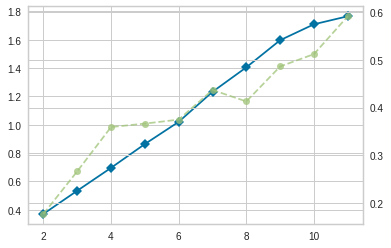

In [ ]:
model = KMeans(random_state=92)
visualizer = KElbowVisualizer(model, k=(2,12), colors = 'yellowbrick')
visualizer.fit(np.array(embedding_expectations)) 

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f0fc639ad68>,
                 k=None, metric=None, model=None, timings=True)

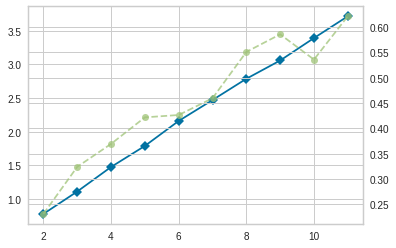

In [ ]:
model = KMeans(random_state=92)
visualizer = KElbowVisualizer(model, k=(2,12), colors = 'yellowbrick')
visualizer.fit(np.array(embedding_expectations_sumary))

In [ ]:
model = KMeans(n_clusters=8, random_state=92)

In [ ]:
model.fit(embedding_expectations)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=92, tol=0.0001, verbose=0)

In [ ]:
model_sumary = KMeans(n_clusters=8, random_state=92)

In [ ]:
model_sumary.fit(embedding_expectations_sumary)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=92, tol=0.0001, verbose=0)

In [ ]:
labels = model.labels_
labels

array([4, 1, 6, ..., 6, 1, 5], dtype=int32)

In [ ]:
labels_sumary = model_sumary.labels_

In [ ]:
movies_details['cluster'] = labels

In [ ]:
movies_details['cluster_sumary'] = labels_sumary

In [ ]:
movies_details['cluster'].value_counts()

1    288
3    270
4    190
5    188
6    133
7    128
2     89
0     53
Name: cluster, dtype: int64

In [ ]:
palavras_centrais = ['Comedy', 'Drama', 'Romance',  'Thriller', 'Animation',  'Sci-Fi', 'Action', 'Adventure']

In [ ]:
def vetor_de_generos(k):
  i = 0
  d={}
  for c in palavras_centrais:
    for lista_genre in movies_details[movies_details['cluster'] == k]['genre'].values:    
      for genre in lista_genre:
       if (genre == c):
          i= i + 1
          d[c] = i
  return d

In [ ]:
def vetor_de_generos_sumary(k):
  i = 0
  d={}
  for c in palavras_centrais:
    for lista_genre in movies_details[movies_details['cluster_sumary'] == k]['genre'].values:    
      for genre in lista_genre:
       if (genre == c):
          i= i + 1
          d[c] = i
  return d

In [ ]:
cluster_0 = vetor_de_generos(0)
cluster_0

{'Action': 67,
 'Adventure': 113,
 'Animation': 16,
 'Comedy': 2,
 'Drama': 10,
 'Romance': 11,
 'Sci-Fi': 25,
 'Thriller': 12}

<BarContainer object of 8 artists>

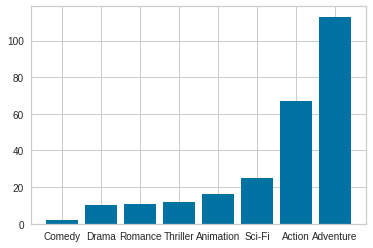

In [ ]:
keys = cluster_0.keys()
values = cluster_0.values()
plt.bar(keys, values)

In [ ]:
cluster_0_sumary = vetor_de_generos_sumary(0)
cluster_0_sumary

{'Action': 292,
 'Adventure': 322,
 'Animation': 198,
 'Comedy': 25,
 'Drama': 130,
 'Romance': 136,
 'Sci-Fi': 210,
 'Thriller': 197}

<BarContainer object of 7 artists>

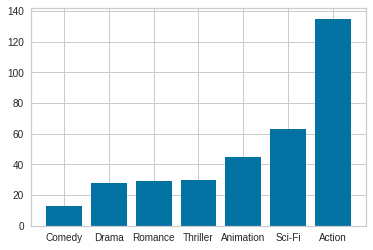

In [ ]:
keys = cluster_0_sumary.keys()
values = cluster_0_sumary.values()
plt.bar(keys, values)

In [ ]:
cluster_1 = vetor_de_generos(1)
cluster_1

{'Action': 518,
 'Adventure': 531,
 'Animation': 509,
 'Comedy': 152,
 'Drama': 351,
 'Romance': 482,
 'Sci-Fi': 516,
 'Thriller': 505}

<BarContainer object of 8 artists>

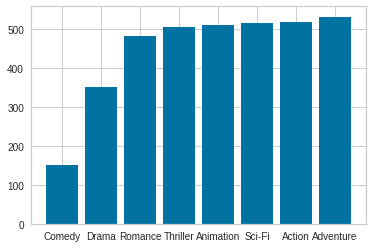

In [ ]:
keys = cluster_1.keys()
values = cluster_1.values()
plt.bar(keys, values)

In [ ]:
cluster_1_sumary = vetor_de_generos_sumary(1)
cluster_1_sumary

{'Action': 231,
 'Adventure': 252,
 'Animation': 200,
 'Comedy': 63,
 'Drama': 165,
 'Romance': 184,
 'Sci-Fi': 210,
 'Thriller': 198}

<BarContainer object of 8 artists>

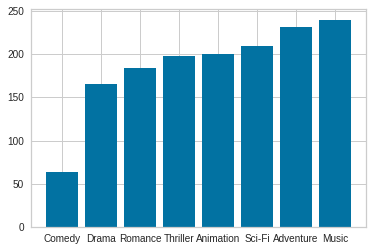

In [ ]:
keys = cluster_1_sumary.keys()
values = cluster_1_sumary.values()
plt.bar(keys, values)

In [ ]:
cluster_2 = vetor_de_generos(2)
cluster_2

{'Action': 139,
 'Adventure': 161,
 'Comedy': 11,
 'Drama': 88,
 'Romance': 97,
 'Sci-Fi': 115,
 'Thriller': 110}

<BarContainer object of 7 artists>

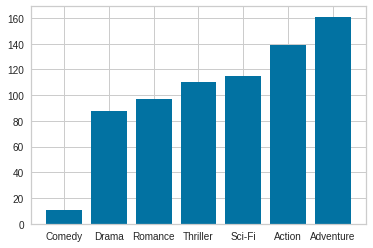

In [ ]:
keys = cluster_2.keys()
values = cluster_2.values()
plt.bar(keys, values)

In [ ]:
cluster_2_sumary = vetor_de_generos_sumary(2)
cluster_2_sumary

{'Action': 361,
 'Adventure': 489,
 'Animation': 157,
 'Comedy': 44,
 'Drama': 95,
 'Romance': 100,
 'Sci-Fi': 250,
 'Thriller': 131}

<BarContainer object of 8 artists>

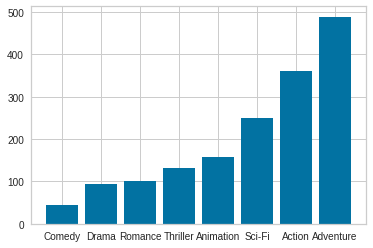

In [ ]:
keys = cluster_2_sumary.keys()
values = cluster_2_sumary.values()
plt.bar(keys, values)

In [ ]:
cluster_3 = vetor_de_generos(3)
cluster_3

{'Action': 408,
 'Adventure': 483,
 'Animation': 285,
 'Comedy': 88,
 'Drama': 201,
 'Romance': 212,
 'Sci-Fi': 324,
 'Thriller': 268}

<BarContainer object of 8 artists>

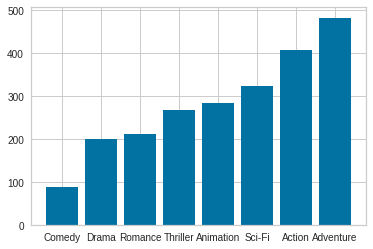

In [ ]:
keys = cluster_3.keys()
values = cluster_3.values()
plt.bar(keys, values)

In [ ]:
cluster_3_sumary = vetor_de_generos_sumary(3)
cluster_3_sumary

{'Action': 204,
 'Adventure': 248,
 'Animation': 117,
 'Comedy': 13,
 'Drama': 83,
 'Romance': 92,
 'Sci-Fi': 143,
 'Thriller': 116}

<BarContainer object of 8 artists>

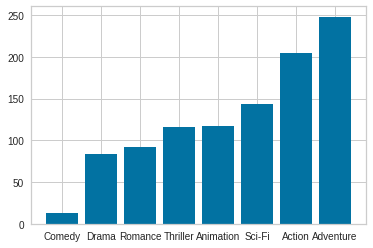

In [ ]:
keys = cluster_3_sumary.keys()
values = cluster_3_sumary.values()
plt.bar(keys, values)

In [ ]:
cluster_4 = vetor_de_generos(4)
cluster_4

{'Action': 282,
 'Adventure': 301,
 'Comedy': 41,
 'Drama': 158,
 'Romance': 166,
 'Sci-Fi': 228,
 'Thriller': 219}

<BarContainer object of 7 artists>

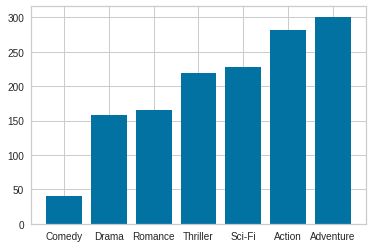

In [ ]:
keys = cluster_4.keys()
values = cluster_4.values()
plt.bar(keys, values)

In [ ]:
cluster_4_sumary = vetor_de_generos_sumary(4)
cluster_4_sumary

{'Action': 286,
 'Adventure': 320,
 'Animation': 270,
 'Comedy': 45,
 'Drama': 180,
 'Romance': 232,
 'Sci-Fi': 276,
 'Thriller': 251}

<BarContainer object of 8 artists>

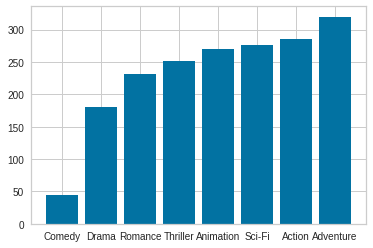

In [ ]:
keys = cluster_4_sumary.keys()
values = cluster_4_sumary.values()
plt.bar(keys, values)

In [ ]:
cluster_5 = vetor_de_generos(5)
cluster_5

{'Action': 349,
 'Adventure': 467,
 'Animation': 117,
 'Comedy': 19,
 'Drama': 62,
 'Romance': 66,
 'Sci-Fi': 207,
 'Thriller': 110}

<BarContainer object of 8 artists>

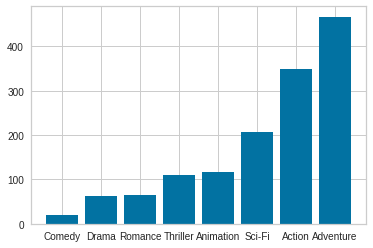

In [ ]:
keys = cluster_5.keys()
values = cluster_5.values()
plt.bar(keys, values)

In [ ]:
cluster_5_sumary = vetor_de_generos_sumary(5)
cluster_5_sumary

{'Action': 407,
 'Adventure': 452,
 'Animation': 372,
 'Comedy': 149,
 'Drama': 265,
 'Romance': 329,
 'Sci-Fi': 387,
 'Thriller': 354}

<BarContainer object of 8 artists>

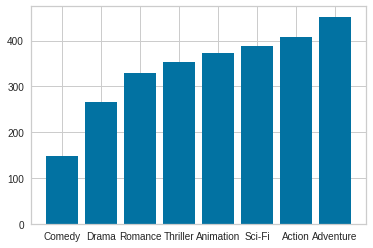

In [ ]:
keys = cluster_5_sumary.keys()
values = cluster_5_sumary.values()
plt.bar(keys, values)

In [ ]:
cluster_6 = vetor_de_generos(6)
cluster_6

{'Action': 214,
 'Adventure': 227,
 'Animation': 193,
 'Comedy': 61,
 'Drama': 152,
 'Romance': 178,
 'Sci-Fi': 202,
 'Thriller': 190}

<BarContainer object of 8 artists>

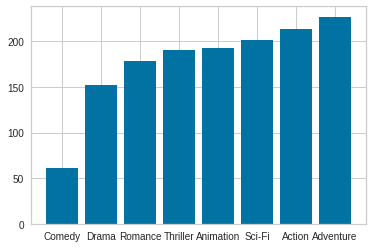

In [ ]:
keys = cluster_6.keys()
values = cluster_6.values()
plt.bar(keys, values)

In [ ]:
cluster_6_sumary = vetor_de_generos_sumary(6)
cluster_6_sumary

{'Action': 89,
 'Adventure': 151,
 'Animation': 24,
 'Comedy': 7,
 'Drama': 16,
 'Romance': 17,
 'Sci-Fi': 35,
 'Thriller': 18}

<BarContainer object of 8 artists>

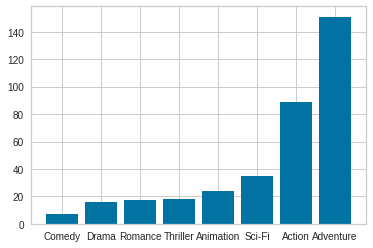

In [ ]:
keys = cluster_6_sumary.keys()
values = cluster_6_sumary.values()
plt.bar(keys, values)

In [ ]:
cluster_7 = vetor_de_generos(7)
cluster_7

{'Action': 164,
 'Adventure': 245,
 'Animation': 118,
 'Comedy': 35,
 'Drama': 66,
 'Romance': 70,
 'Sci-Fi': 130,
 'Thriller': 80}

<BarContainer object of 8 artists>

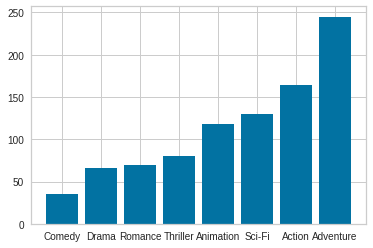

In [ ]:
keys = cluster_7.keys()
values = cluster_7.values()
plt.bar(keys, values)

In [ ]:
cluster_7_sumary = vetor_de_generos_sumary(7)
cluster_7_sumary

{'Action': 271,
 'Adventure': 294,
 'Comedy': 63,
 'Drama': 154,
 'Romance': 192,
 'Sci-Fi': 236,
 'Thriller': 229}

<BarContainer object of 7 artists>

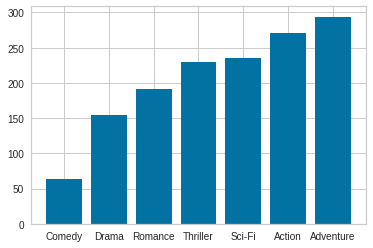

In [ ]:
keys = cluster_7_sumary.keys()
values = cluster_7_sumary.values()
plt.bar(keys, values)

##Lista de recomendação

In [ ]:
def vetor_5_nomes(k):
  i=0
  for id in movies_details[movies_details['cluster'] == k]['movie_id'].values:   
    if(i>6):
      break
    title = movies[movies['imdb_title_id'] == id]['title'].values
    print('___________________________')
    print(title)
    print('___________________________')
    i=i+1

In [ ]:
def vetor_5_nomes_sumary(k):
  i=0
  for id in movies_details[movies_details['cluster_sumary'] == k]['movie_id'].values:   
    if(i>6):
      break
    title = movies[movies['imdb_title_id'] == id]['title'].values
    print('___________________________')
    print(title)
    print('___________________________')
    i=i+1

In [ ]:
vetor_5_nomes_sumary(0)

___________________________
['Patriot Games']
___________________________
___________________________
['The World Is Not Enough']
___________________________
___________________________
['I, Robot']
___________________________
___________________________
['The Usual Suspects']
___________________________
___________________________
[]
___________________________
___________________________
['In the Name of the Father']
___________________________
___________________________
['The Insider']
___________________________


In [ ]:
vetor_5_nomes(0)

___________________________
['Star Wars: Episode II - Attack of the Clones']
___________________________
___________________________
['The Chronicles of Narnia: Prince Caspian']
___________________________
___________________________
['Rogue One']
___________________________
___________________________
['Pirates of the Caribbean: On Stranger Tides']
___________________________
___________________________
['X-Men']
___________________________
___________________________
['300']
___________________________
___________________________
['The Scorpion King']
___________________________


In [ ]:
vetor_5_nomes_sumary(1)

___________________________
['The Treasure of the Sierra Madre']
___________________________
___________________________
['Election']
___________________________
___________________________
['Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan']
___________________________
___________________________
['The Imitation Game']
___________________________
___________________________
['The Net']
___________________________
___________________________
['Rocky V']
___________________________
___________________________
['Sabrina']
___________________________


In [ ]:
vetor_5_nomes(1)

___________________________
['Last Vegas']
___________________________
___________________________
["Bridget Jones's Diary"]
___________________________
___________________________
['The Parent Trap']
___________________________
___________________________
['Mean Girls']
___________________________
___________________________
['The Piano']
___________________________
___________________________
['Blue Valentine']
___________________________
___________________________
['Sabrina']
___________________________


In [ ]:
vetor_5_nomes_sumary(2)

___________________________
['Hulk']
___________________________
___________________________
['Aliens']
___________________________
___________________________
['Blood Diamond']
___________________________
___________________________
['The Cabin in the Woods']
___________________________
___________________________
['Planet of the Apes']
___________________________
___________________________
[]
___________________________
___________________________
['Brave']
___________________________


In [ ]:
vetor_5_nomes(2)

___________________________
['Blood Diamond']
___________________________
___________________________
['Metropolis']
___________________________
___________________________
['Enemy at the Gates']
___________________________
___________________________
['The Insider']
___________________________
___________________________
['The Da Vinci Code']
___________________________
___________________________
['The Man in the Iron Mask']
___________________________
___________________________
['Andrei Rublev']
___________________________


In [ ]:
vetor_5_nomes_sumary(3)

___________________________
['Saving Private Ryan']
___________________________
___________________________
['Enemy at the Gates']
___________________________
___________________________
['Das Boot']
___________________________
___________________________
['Rogue One']
___________________________
___________________________
['The Hunt for Red October']
___________________________
___________________________
['Captain America: The First Avenger']
___________________________
___________________________
['Iron Man 2']
___________________________


In [ ]:
vetor_5_nomes(3)

___________________________
['The Cabin in the Woods']
___________________________
___________________________
['Ghostbusters']
___________________________
___________________________
['Spring Breakers']
___________________________
___________________________
['The Net']
___________________________
___________________________
['Toy Story 2']
___________________________
___________________________
['Madagascar']
___________________________
___________________________
['Triangle']
___________________________


In [ ]:
vetor_5_nomes_sumary(4)

___________________________
['The Descent']
___________________________
___________________________
['The Parent Trap']
___________________________
___________________________
['Metropolis']
___________________________
___________________________
['The Piano']
___________________________
___________________________
['Blue Valentine']
___________________________
___________________________
['Sunrise: A Song of Two Humans']
___________________________
___________________________
['Buffy the Vampire Slayer']
___________________________


In [ ]:
vetor_5_nomes(4)

___________________________
['Patriot Games']
___________________________
___________________________
['The Usual Suspects']
___________________________
___________________________
['True Romance']
___________________________
___________________________
[]
___________________________
___________________________
['In the Name of the Father']
___________________________
___________________________
['Basic Instinct']
___________________________
___________________________
['Salinui chueok']
___________________________


In [ ]:
vetor_5_nomes(5)

___________________________
['Hulk']
___________________________
___________________________
['Aliens']
___________________________
___________________________
['The World Is Not Enough']
___________________________
___________________________
['I, Robot']
___________________________
___________________________
['Saving Private Ryan']
___________________________
___________________________
['Star Trek: Nemesis']
___________________________
___________________________
['The Hunger Games: Catching Fire']
___________________________


##TSNE

In [ ]:
from yellowbrick.text import TSNEVisualizer

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

TSNEVisualizer(alpha=0.7,
               ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f0fcf1ee3c8>,
               classes=None, colormap=None, colors='yellowbrick',
               decompose=None, decompose_by=None, labels=None,
               random_state=None)

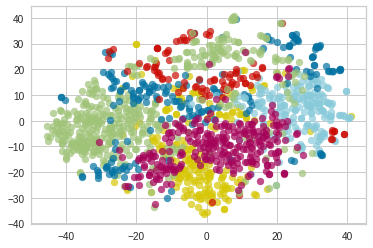

In [ ]:
visualizer = TSNEVisualizer(colors='yellowbrick')
visualizer.fit(embedding_expectations, labels)       

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

TSNEVisualizer(alpha=0.7,
               ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f0fcf22a358>,
               classes=None, colormap=None, colors='yellowbrick',
               decompose=None, decompose_by=None, labels=None,
               random_state=None)

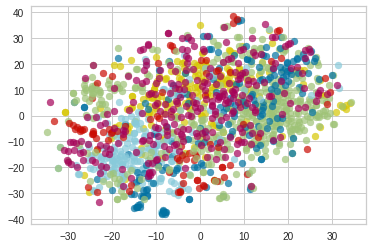

In [ ]:
visualizer = TSNEVisualizer(colors='yellowbrick')
visualizer.fit(embedding_expectations_sumary, labels)  

#Vader

In [ ]:
 pip install vaderSentiment

     |████████████████████████████████| 133kB 2.7MB/s 


In [ ]:
movies_reviews_filtrado = movies_reviews['review_text'][0::10]

In [ ]:
len(movies_reviews_filtrado)

57392

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [ ]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score

In [ ]:
score_reviews = [sentiment_analyzer_scores(e) for e in movies_reviews_filtrado]
score_reviews

In [ ]:
movies_id_filtrado = movies_reviews['movie_id'][0::10]

In [ ]:
score_processado = []
for score  in score_reviews:
  s  = score['compound']
  novo_score = ((10*(s+1))/2)
  novo_score = "%.1f" % novo_score
  score_processado.append(novo_score)

#imprimir parte do resultado
score_processado[0::5000]

['10.0',
 '10.0',
 '9.9',
 '9.1',
 '0.0',
 '9.9',
 '7.0',
 '6.0',
 '10.0',
 '0.3',
 '10.0',
 '9.9']

In [ ]:
#comparar resultado do Vader com o valor avaliado pela pessoa
movies_ratings_filtrado = movies_reviews['rating'][0::10]

In [ ]:
movies_id_filtrado = movies_reviews['movie_id'][0::10]

In [ ]:
movies_id_filtrado[0]

'tt0111161'

In [ ]:
novo_score=score_processado

In [ ]:
#plotar parte dos dados para comparação
d={}
i = 0
for rating in movies_ratings_filtrado[0::5000]:
    id = movies_id_filtrado[i]
    title = movies[movies['imdb_title_id'] == id]['title'].values
    print('___________________________')
    print(title)
    print('score tabela = ' + str(rating) + '\n')
    print('score calculado = ' + str(novo_score[i]) + '\n')
    print('___________________________')
    print('\n')
    i = i+5000


    


___________________________
['The Shawshank Redemption']
score tabela = 10

score calculado = 10.0

___________________________


___________________________
['The Godfather']
score tabela = 10

score calculado = 10.0

___________________________


___________________________
['The Dark Knight']
score tabela = 8

score calculado = 9.9

___________________________


___________________________
['Pulp Fiction']
score tabela = 9

score calculado = 9.1

___________________________


___________________________
['Fight Club']
score tabela = 3

score calculado = 0.0

___________________________


___________________________
['The Matrix']
score tabela = 4

score calculado = 9.9

___________________________


___________________________
['Sen to Chihiro no kamikakushi']
score tabela = 10

score calculado = 7.0

___________________________


___________________________
['Rear Window']
score tabela = 6

score calculado = 6.0

___________________________


___________________________
['Nuovo Cin

##Naive Bayes

In [ ]:
#pre processamento sinopses
reviews_preprocessadas = [pre_text_processing (synopse) for synopse in movies_reviews['review_text'][0::100]]

In [ ]:
len(reviews_preprocessadas)

5740

In [ ]:
vect_bag = CountVectorizer()
vect_bag

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
frases = []
for review in reviews_preprocessadas:
  frase = []
  for palavra in review:
    frase.append(palavra)
  string = ' '.join(frase)
  frases.append(string)  

In [ ]:
docs_bag = vect_bag.fit_transform(frases)

In [ ]:
docs_bag=docs_bag.toarray()

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    docs_bag,
                                                    movies_reviews['is_spoiler'][0::100],
                                                    random_state=0)


In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

In [ ]:
print("Nº de erros da classificação {0} de {1}".format((y_test != y_pred).sum(), docs_bag.shape[0]))

Nº de erros da classificação 663 de 5740


In [ ]:
print("------------------Estatísticas de treinamento------------------")
print("Acurácia:", gnb.score(X_train, y_train))
y_pred = gnb.predict(X_train)
print("Acurácia de previsão:", accuracy_score(y_train, y_pred))
print(classification_report(y_train, 
                            y_pred, 
                            target_names=["True", "False"]))

cnf_matrix = confusion_matrix(y_train, y_pred)
cnf_table = pd.DataFrame(data=cnf_matrix,
                         index=["Is_Spoiler=False", "Is_Spoiler=True"],
                         columns=["Is_Spoiler(prev)=False",
                                  "Prev. Is_Spoiler(prev)=True"])
print(cnf_table)


------------------Estatísticas de treinamento------------------
Acurácia: 0.9212543554006969
Acurácia de previsão: 0.9212543554006969
              precision    recall  f1-score   support

        True       1.00      0.89      0.94      3181
       False       0.77      1.00      0.87      1124

    accuracy                           0.92      4305
   macro avg       0.88      0.95      0.91      4305
weighted avg       0.94      0.92      0.92      4305

                  Is_Spoiler(prev)=False  Prev. Is_Spoiler(prev)=True
Is_Spoiler=False                    2842                          339
Is_Spoiler=True                        0                         1124


In [ ]:
print("\n\n------------------Estatísticas de teste------------------")
y_pred_test = gnb.predict(X_test)
print("Acurácia de previsão:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, 
                            y_pred_test, 
                             target_names=["True", "False"]))

cnf_matrix_test = confusion_matrix(y_test, y_pred_test)
cnf_table_test = pd.DataFrame(data=cnf_matrix_test,
                              index=["Is_Spoiler=False", "Is_Spoiler=True"],
                              columns=["Is_Spoiler(prev)=False",
                                  "Prev. Is_Spoiler(prev)=True"])
print(cnf_table_test, '\n\n')



------------------Estatísticas de teste------------------
Acurácia de previsão: 0.537979094076655
              precision    recall  f1-score   support

        True       0.71      0.64      0.67      1061
       False       0.20      0.25      0.22       374

    accuracy                           0.54      1435
   macro avg       0.45      0.45      0.45      1435
weighted avg       0.57      0.54      0.55      1435

                  Is_Spoiler(prev)=False  Prev. Is_Spoiler(prev)=True
Is_Spoiler=False                     678                          383
Is_Spoiler=True                      280                           94 


